# Optimizing Traditional Machine Learning Methods for Facial Recognition: A Comparative Analysis with LFW Dataset                                                                          

## Introduction

In today's digital age, the demand for robust and efficient facial recognition systems has surged across various domains, including security, authentication, surveillance, and human-computer interaction. The ability to accurately identify and verify individuals from images or video streams holds immense potential for enhancing security protocols, streamlining authentication processes, and improving user experiences in various applications.

The goal of this project is to develop a facial recognition system using Support Vector Machines (SVM), a powerful machine learning algorithm known for its effectiveness in classification tasks. We leverage the Labeled Faces in the Wild (LFW) dataset, a widely used benchmark dataset in the field of face recognition, containing a diverse set of facial images collected from the web.

Our approach involves several key steps, including data preprocessing, feature extraction using Principal Component Analysis (PCA) for dimensionality reduction, model building using SVM with hyperparameter tuning, and comprehensive evaluation of the model's performance.

Through this project, we aim to demonstrate the efficacy of SVM-based facial recognition systems and explore the impact of various factors, such as hyperparameters and feature representation, on the system's performance. Additionally, we seek to gain insights into the challenges and opportunities associated with building and deploying facial recognition systems in real-world scenarios.

In the following sections, we provide a detailed overview of the dataset, our methodology, experimental setup, results, and discussion, followed by conclusions and avenues for future research.

## Standard Imports

These are the libraries we have been working with throughout the semester. 

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_lfw_people

## Dataset

The Labeled Faces in the Wild (LFW) dataset, accessible through the scikit-learn library, is a widely used benchmark dataset for face recognition tasks. It consists of a collection of facial images extracted from various online sources, such as news articles, Google Images, and celebrity websites. The dataset contains images of faces belonging to different individuals, captured under a variety of conditions, including varying lighting, pose, and facial expressions. 

With over 13,000 images of approximately 5,000 individuals, LFW offers a diverse and challenging dataset for evaluating the performance of facial recognition algorithms. Each image in the dataset is labeled with the corresponding identity of the individual depicted, providing ground truth for training and evaluation purposes. This rich and expansive dataset serves as a valuable resource for researchers and practitioners working in the field of computer vision and machine learning, facilitating advancements in facial recognition technology.

For the purpose of this project, I only import those persons who have atleast 50 unique images. This ensures our model has enough data to train on to classify a particular individual. This is ensured by the *min_faces_per_person* argument. Furthermore, the images are resized to 40% of their original size to maximize efficiency and speed.

In [6]:
#import the data through sklearn
sk_data = fetch_lfw_people(min_faces_per_person=50, resize=0.6)

#extract features, labels, and names from the data
feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names

n_samples, n_features = feature_vectors.shape
N, h, w = sk_data.images.shape
n_classes = len(categories)

The following cell helps us understand the dataset in greater depth. We see the distribution of images for different people. The code prints the number of unique images associated with each person.

In [7]:
images_per_person = {}

# Count the number of images for each person
for label in class_labels:
    if label in images_per_person:
        images_per_person[label] += 1
    else:
        images_per_person[label] = 1

# Print the count of images for each person
for person_id, count in images_per_person.items():
    person_name = categories[person_id]
    print(f"{person_name} has {count} images.")

Tony Blair has 144 images.
Gerhard Schroeder has 109 images.
Donald Rumsfeld has 121 images.
George W Bush has 530 images.
Colin Powell has 236 images.
Ariel Sharon has 77 images.
Serena Williams has 52 images.
John Ashcroft has 53 images.
Hugo Chavez has 71 images.
Jean Chretien has 55 images.
Junichiro Koizumi has 60 images.
Jacques Chirac has 52 images.


Now, we aim to visualize our dataset. The following code prints out one image for each person in the dataset, in grayscale. As we can see, we have 12 unique individuals in this dataset.

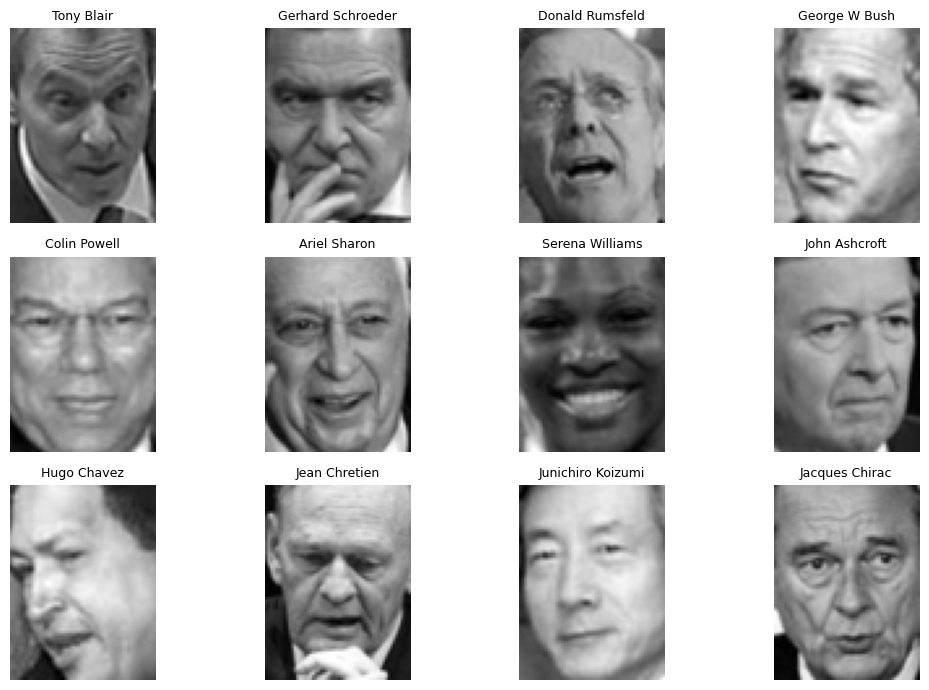

In [8]:
images = sk_data.images
fig, axes = plt.subplots(3, 4, figsize=(11, 7))
axes = axes.ravel()

for i, (person_id, count) in enumerate(images_per_person.items()):
    idx = (class_labels == person_id).argmax()
    # Plot the image
    axes[i].imshow(images[idx], cmap='gray')
    axes[i].set_title(categories[person_id], size=9)
    axes[i].axis('off')

plt.tight_layout()
#plt.savefig('Images.png', dpi=400, format='png')

## Preprocessing - PCA and Train-Test Split

We apply the Principal Component Analysis (PCA) algorithm as a crucial preprocessing step to reduce the dimensionality of the feature space. PCA enables us to transform the high-dimensional feature vectors extracted from facial images into a lower-dimensional representation while preserving as much of the original variance as possible. By retaining the most informative components and discarding less relevant ones, PCA simplifies the computational complexity of subsequent processing steps and mitigates the curse of dimensionality. 

This reduction in dimensionality not only expedites the training process but also helps in combating overfitting, thereby enhancing the generalization capability of the model. Furthermore, PCA aids in uncovering the underlying structure and patterns present in the data, facilitating better interpretation and understanding of the feature space. Overall, the application of PCA in this project is essential for optimizing the efficiency and effectiveness of the facial recognition system, ultimately improving its performance and usability in real-world applications.

We can see this process takes the original feature matrix of the shape (1560, 1850), and transforms into a new PCA matrix of shape (1560, 172). We then apply a standard train-test split to this transformed matrix.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import random

print('Feature matrix shape is: ', feature_vectors.shape)

# Standard scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_vectors)

# Perform PCA
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(scaled_features)
print("PCA features shape:", pca_features.shape)

Feature matrix shape is:  (1560, 4200)
PCA features shape: (1560, 202)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(pca_features, class_labels, test_size=0.1, random_state=42)

## Building an SVM Model

We employ a Support Vector Machine (SVM) algorithm for facial recognition, leveraging its robust classification capabilities. The SVM algorithm is particularly well-suited for binary and multiclass classification tasks, making it an ideal choice for our facial recognition system. By maximizing the margin between different classes in the feature space, SVM aims to find an optimal hyperplane that separates the data points belonging to different individuals.

Through extensive hyperparameter tuning using techniques such as GridSearchCV, we identify the most suitable parameters for our SVM model, including the regularization parameter (C) and the kernel coefficient (gamma). This meticulous parameter optimization process ensures that our SVM model generalizes well to unseen data and achieves high accuracy in classifying facial images. By harnessing the power of SVM, we aim to build a robust and reliable facial recognition system capable of accurately identifying individuals across diverse conditions and scenarios.

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
import numpy as np

param_grid = {
    'C': np.logspace(-4, 4, 7),  
    'gamma': np.logspace(-4, -1, 5),  # Focus on a few meaningful gamma values
    'kernel': ['linear', 'rbf'],  # Start with only common kernels
    'class_weight': ['balanced', None]  # Use balanced class weights
}

# Set up stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV or RandomizedSearchCV object
svm = GridSearchCV(
    estimator=SVC(),  # Use a Support Vector Classifier
    param_grid=param_grid,  # Hyperparameters to tune
    scoring='accuracy',  # Use balanced scoring metric
    cv=cv,
    verbose=0,  # Monitor progress
    n_jobs=-1,  # Use all available CPU cores
)

# Train the model
start = time.time()
print("Fitting the classifier to the training set...")
svm.fit(X_train, y_train)
end = time.time()

# Print the best results
print("Best estimator found by randomized search:")
print(svm.best_estimator_)
print("Best parameters found by randomized search:")
print(svm.best_params_)
print("Runtime:", end - start)

Fitting the classifier to the training set...
Best estimator found by randomized search:
SVC(C=464.1588833612773, class_weight='balanced', gamma=0.0001)
Best parameters found by randomized search:
{'C': 464.1588833612773, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}
Runtime: 34.731143951416016


## Testing the Model

Following the training of our Support Vector Machine (SVM) classification model, we proceed to make predictions on the test set to assess its performance and accuracy. Leveraging the best estimator obtained through GridSearchCV, we apply the trained SVM model to the unseen test data. By predicting the identities of individuals depicted in the test images, we evaluate the model's ability to generalize to new and unseen data. Subsequently, we calculate the accuracy of the model by comparing its predictions to the ground truth labels. Additionally, we generate a detailed classification report, which provides insights into the precision, recall, and F1-score for each class in the dataset. This comprehensive evaluation allows us to assess the model's performance across different classes and identify any potential areas for improvement. Moreover, we visualize the results using a confusion matrix, which provides a clear depiction of the model's performance in classifying different individuals. By analyzing these metrics and visualizations, we gain a deeper understanding of the SVM model's effectiveness in facial recognition tasks and its overall accuracy in identifying individuals from facial images.

Predicting names on the test set
Accuracy: 78.8%
                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.80      0.67         5
     Colin Powell       0.81      0.96      0.88        27
  Donald Rumsfeld       0.71      0.77      0.74        13
    George W Bush       0.86      0.85      0.85        52
Gerhard Schroeder       0.60      0.50      0.55        12
      Hugo Chavez       0.75      0.67      0.71         9
   Jacques Chirac       1.00      0.67      0.80         3
    Jean Chretien       0.71      0.83      0.77         6
    John Ashcroft       1.00      0.80      0.89         5
Junichiro Koizumi       1.00      0.75      0.86         4
  Serena Williams       1.00      0.60      0.75         5
       Tony Blair       0.67      0.67      0.67        15

         accuracy                           0.79       156
        macro avg       0.81      0.74      0.76       156
     weighted avg       0.80      0.79      0.79       156



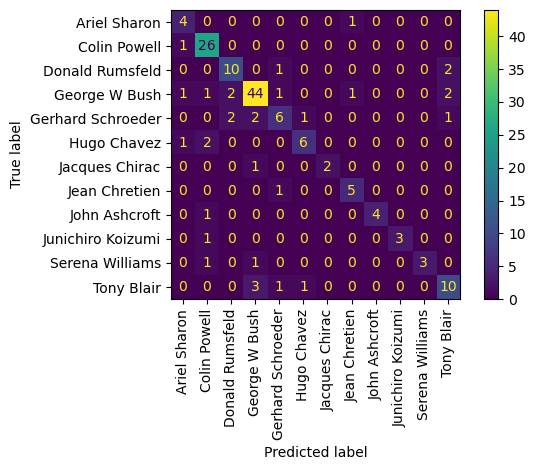

In [12]:
print("Predicting names on the test set")
svm_best = svm.best_estimator_
pred = svm_best.predict(X_test)

print(f"Accuracy: {svm_best.score(X_test, y_test)*100:.1f}%")
print(classification_report(y_test, pred, target_names=categories))

ConfusionMatrixDisplay.from_estimator(
    svm, X_test, y_test, display_labels=categories, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

## Building a Logistic Regression Model

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Define the parameter grid
param_grid = {
    'estimator__C': np.logspace(-3, 3, 5),  # Narrow down to values like [0.01, 0.1, 1, 10, 100]
    'estimator__class_weight': ['balanced', None]  # Use balanced class weights
}

# Create the RandomizedSearchCV object with OneVsRestClassifier
lr = GridSearchCV(
    estimator=OneVsRestClassifier(LogisticRegression(max_iter=2000)),  # Use OvR Logistic Regression Classifier
    param_grid=param_grid,  # Use the refined parameter grid
    scoring='accuracy',  # Use balanced scoring metric
    cv=cv,
    verbose=0,  # Monitor progress
    n_jobs=-1,  # Use all available CPU cores
)

# Train the model
start = time.time()
print("Fitting the classifier to the training set...")
lr.fit(X_train, y_train)
end = time.time()

# Print the best results
print("Best estimator found by randomized search:")
print(lr.best_estimator_)
print("Best parameters found by randomized search:")
print(lr.best_params_)
print("Runtime:", end - start)

Fitting the classifier to the training set...
Best estimator found by randomized search:
OneVsRestClassifier(estimator=LogisticRegression(C=0.001,
                                                 class_weight='balanced',
                                                 max_iter=2000))
Best parameters found by randomized search:
{'estimator__C': 0.001, 'estimator__class_weight': 'balanced'}
Runtime: 8.384061813354492


Predicting names on the test set
Accuracy: 81.4%
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.80      0.73         5
     Colin Powell       0.89      0.89      0.89        27
  Donald Rumsfeld       0.60      0.69      0.64        13
    George W Bush       0.93      0.81      0.87        52
Gerhard Schroeder       0.82      0.75      0.78        12
      Hugo Chavez       1.00      0.67      0.80         9
   Jacques Chirac       0.75      1.00      0.86         3
    Jean Chretien       0.71      0.83      0.77         6
    John Ashcroft       0.83      1.00      0.91         5
Junichiro Koizumi       1.00      0.50      0.67         4
  Serena Williams       0.80      0.80      0.80         5
       Tony Blair       0.64      0.93      0.76        15

         accuracy                           0.81       156
        macro avg       0.80      0.81      0.79       156
     weighted avg       0.84      0.81      0.82       156



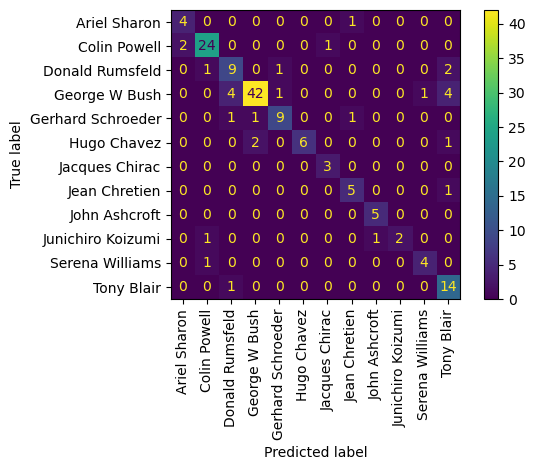

In [16]:
# Test the model
print("Predicting names on the test set")
lr_best = lr.best_estimator_
pred = lr_best.predict(X_test)

print(f"Accuracy: {lr_best.score(X_test, y_test)*100:.1f}%")
print(classification_report(y_test, pred, target_names=categories))

ConfusionMatrixDisplay.from_estimator(
    lr, X_test, y_test, display_labels=categories, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

## Building a Nearest Neighbors Classifier

In [17]:
# Train and tune a KNN classifier
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],      # Uniform weights or distance-based weights
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metrics
    'p': [1, 2, 3]  # Minkowski metric parameter (1 = Manhattan, 2 = Euclidean, 3+ = Generalized)
}

# Create the GridSearchCV object
knn = GridSearchCV(
    estimator=KNeighborsClassifier(),  # Use a KNN classifier
    param_grid=param_grid,  # Hyperparameters to tune
    scoring='accuracy',  # Use balanced scoring metric
    cv=cv,
    verbose=0,  # Monitor progress
    n_jobs=-1,  # Use all available CPU cores
)

# Train the model
start = time.time()
print("Fitting the classifier to the training set...")
knn.fit(X_train, y_train)
end = time.time()

# Print the best results
print("Best estimator found by randomized search:")
print(knn.best_estimator_)
print("Best parameters found by randomized search:")
print(knn.best_params_)
print("Runtime:", end - start)

Fitting the classifier to the training set...
Best estimator found by randomized search:
KNeighborsClassifier(metric='manhattan', n_neighbors=3, p=1, weights='distance')
Best parameters found by randomized search:
{'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Runtime: 11.381484985351562


Predicting names on the test set
Accuracy: 66.7%
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.60      0.55         5
     Colin Powell       0.83      0.70      0.76        27
  Donald Rumsfeld       0.56      0.69      0.62        13
    George W Bush       0.67      0.81      0.73        52
Gerhard Schroeder       0.80      0.33      0.47        12
      Hugo Chavez       0.60      0.33      0.43         9
   Jacques Chirac       0.00      0.00      0.00         3
    Jean Chretien       0.67      0.67      0.67         6
    John Ashcroft       0.83      1.00      0.91         5
Junichiro Koizumi       0.50      0.50      0.50         4
  Serena Williams       1.00      0.60      0.75         5
       Tony Blair       0.56      0.67      0.61        15

         accuracy                           0.67       156
        macro avg       0.63      0.58      0.58       156
     weighted avg       0.67      0.67      0.66       156



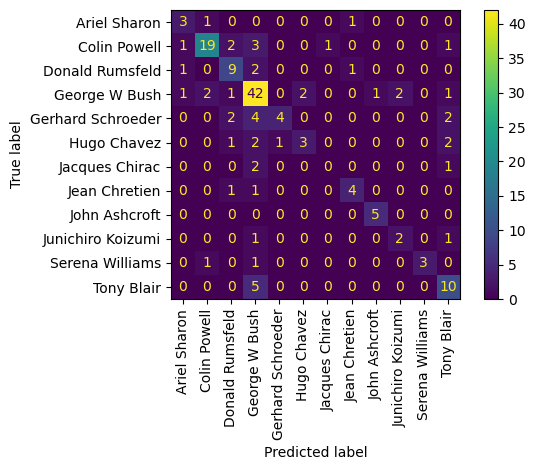

In [18]:
# Test the model
print("Predicting names on the test set")
knn_best = knn.best_estimator_
pred = knn_best.predict(X_test)

print(f"Accuracy: {knn_best.score(X_test, y_test)*100:.1f}%")
print(classification_report(y_test, pred, target_names=categories))

ConfusionMatrixDisplay.from_estimator(
    knn, X_test, y_test, display_labels=categories, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

# Building a LDA Model

In [56]:
# Train and tune an LDA classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import make_scorer, accuracy_score

# Define the custom scoring function
def weighted_accuracy(estimator, X, y):
    # Compute sample weights dynamically
    sample_weights = compute_sample_weight(class_weight="balanced", y=y)
    # Get predictions
    y_pred = estimator.predict(X)
    # Return weighted accuracy
    return accuracy_score(y, y_pred, sample_weight=sample_weights)


# Define a conditional parameter grid
param_grid = [
    {'solver': ['svd'],  # Shrinkage is not supported with 'svd'
     'tol': [1e-4, 1e-3, 1e-2, 1e-1]},
    {'solver': ['lsqr', 'eigen'],  # Shrinkage is supported with 'lsqr' and 'eigen'
     'shrinkage': [None, 'auto', 0.1, 0.5, 1],
     'tol': [1e-4, 1e-3, 1e-2, 1e-1]},
]

# Create the GridSearchCV object
lda = GridSearchCV(
    estimator=LinearDiscriminantAnalysis(),  # Use a LDA classifier
    param_grid=param_grid,  # Hyperparameters to tune
    scoring=weighted_accuracy,  # Use balanced scoring metric
    cv=cv,
    verbose=0,  # Monitor progress
    n_jobs=-1,  # Use all available CPU cores
)

# Balance the training set

# Train the model
start = time.time()
print("Fitting the classifier to the training set...")
lda.fit(X_train, y_train)
end = time.time()

# Print the best results
print("Best estimator found by randomized search:")
print(lda.best_estimator_)
print("Best parameters found by randomized search:")
print(lda.best_params_)
print("Runtime:", end - start)

Fitting the classifier to the training set...
Best estimator found by randomized search:
LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')
Best parameters found by randomized search:
{'shrinkage': 0.1, 'solver': 'lsqr', 'tol': 0.0001}
Runtime: 1.3563530445098877


Predicting names on the test set
Accuracy: 81.4%
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.80      0.73         5
     Colin Powell       0.89      0.93      0.91        27
  Donald Rumsfeld       0.82      0.69      0.75        13
    George W Bush       0.85      0.85      0.85        52
Gerhard Schroeder       0.75      0.75      0.75        12
      Hugo Chavez       0.75      0.67      0.71         9
   Jacques Chirac       1.00      0.33      0.50         3
    Jean Chretien       0.56      0.83      0.67         6
    John Ashcroft       1.00      1.00      1.00         5
Junichiro Koizumi       1.00      0.75      0.86         4
  Serena Williams       1.00      0.60      0.75         5
       Tony Blair       0.72      0.87      0.79        15

         accuracy                           0.81       156
        macro avg       0.83      0.76      0.77       156
     weighted avg       0.83      0.81      0.81       156



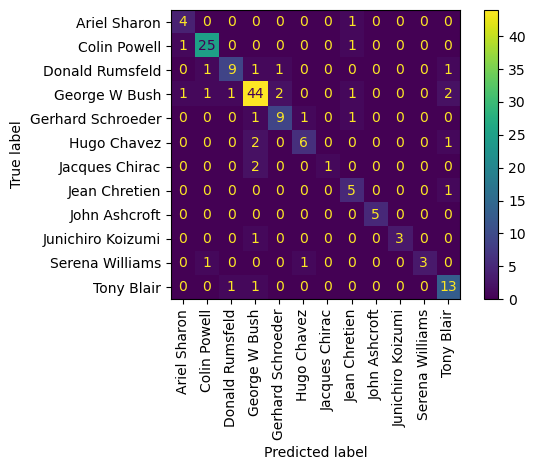

In [57]:
# Test the model
print("Predicting names on the test set")
lda_best = lda.best_estimator_
pred = lda_best.predict(X_test)

print(f"Accuracy: {lda_best.score(X_test, y_test)*100:.1f}%")
print(classification_report(y_test, pred, target_names=categories))

ConfusionMatrixDisplay.from_estimator(
    lda, X_test, y_test, display_labels=categories, xticks_rotation="vertical"
)

plt.tight_layout()
plt.show()

## Compare Model Performance

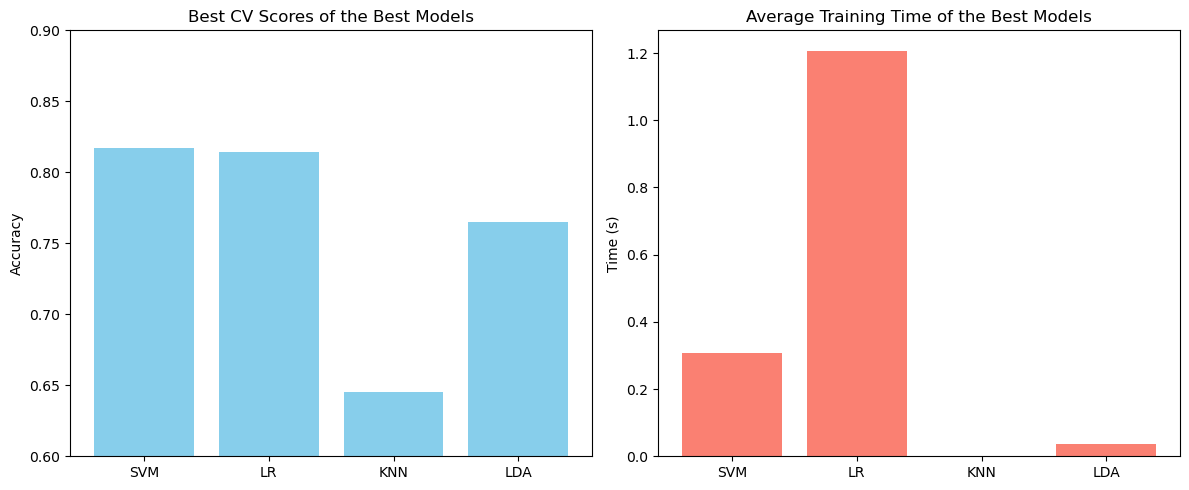

In [58]:
# Compare and plot best cv scores of the best models
import pandas as pd

scores = np.array([svm.best_score_, lr.best_score_, knn.best_score_, lda.best_score_])
times = np.array([svm.cv_results_['mean_fit_time'].mean(), lr.cv_results_['mean_fit_time'].mean(), knn.cv_results_['mean_fit_time'].mean(), lda.cv_results_['mean_fit_time'].mean()])
models = ['SVM', 'LR', 'KNN', 'LDA']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, scores, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Best CV Scores of the Best Models')
plt.ylim(0.6, 0.9)

plt.subplot(1, 2, 2)
plt.bar(models, times, color='salmon')
plt.ylabel('Time (s)')
plt.title('Average Training Time of the Best Models')

plt.tight_layout()
plt.show()


## Picking the best model

From the plots above, we can compare the performance of four traditional ML methods - SVMs, Logistic Regression, KNN, and LDAs. From the plot on the left, it is clear that KNN performs the worst, while the other three have very similar performances with LDA barely eeking out. However, the plot on the right shows a clear winner - LDA takes the lease time to train and fit while giving better performance. 

Keeping these metrics in mind, I go ahead with LDA for the rest of the notebook, picking that as the model of choice.

## Visualizing the Predictions

The provided function `plot_gallery` serves as a visualization tool to plot a gallery of sample images from the test set along with their corresponding predicted and actual labels. The function takes as input the test images (`images`), the true labels (`true_titles`), the predicted labels (`pred_titles`), as well as the height (`h`) and width (`w`) dimensions of the images. Additionally, the function allows customization of the layout with parameters `n_row` and `n_col`, which specify the number of rows and columns in the grid of subplots.

Within the function, each image is reshaped to its original dimensions using the Principal Component Analysis (PCA) components, allowing for visualization in its original format. The images are then plotted as grayscale portraits, with the predicted label displayed as the subplot title and the actual label as the xlabel. By utilizing Matplotlib's subplot functionality, the function generates a grid of subplots containing the sample images, enabling easy comparison between the predicted and actual labels.

/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_56671/2918101140.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


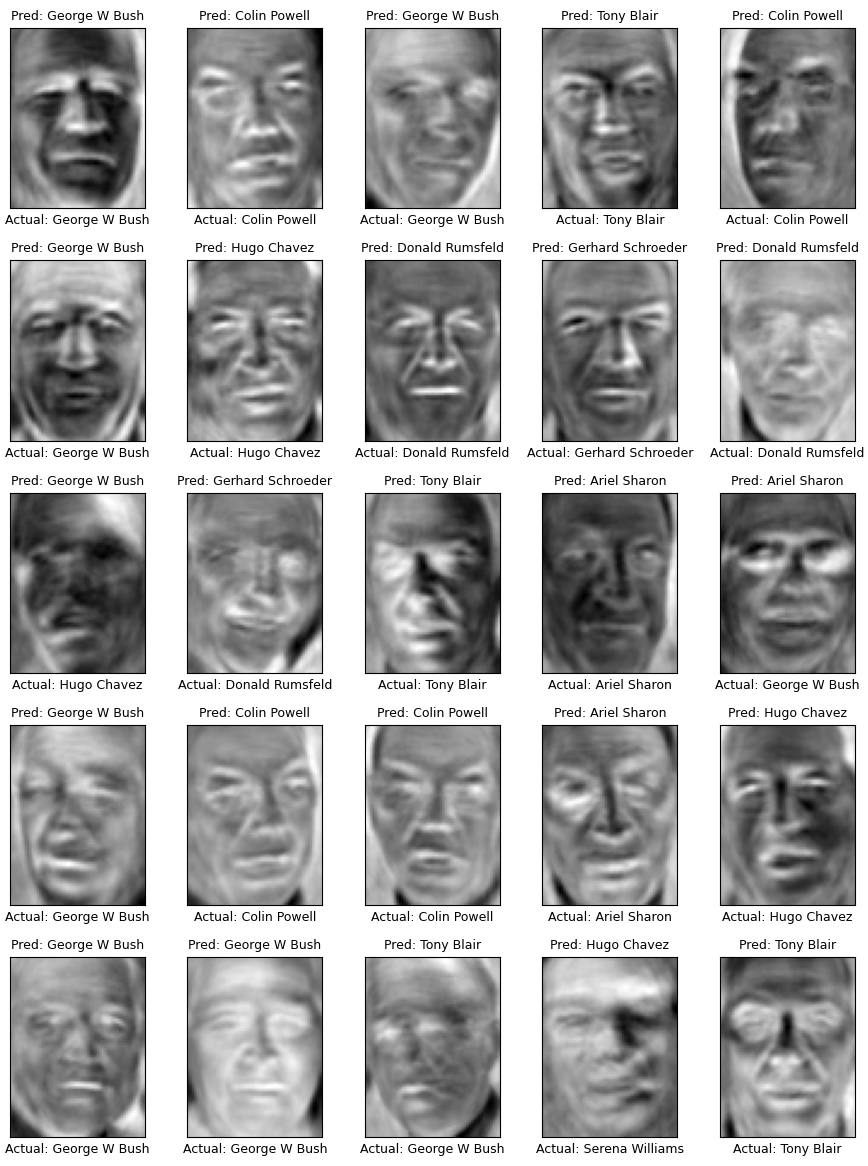

In [59]:
def plot_gallery(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        img = np.dot(images[i], pca.components_).reshape((h, w))
        plt.imshow(img, cmap=plt.cm.gray_r)
        plt.title('Pred: '+str(categories[pred_titles[i]]), size=9)
        plt.xlabel('Actual: '+str(categories[true_titles[i]]), size=9)
        plt.tight_layout()
        plt.xticks(())
        plt.yticks(())

pred = lda_best.predict(X_test)
plot_gallery(X_test, y_test, pred, h,w)
plt.savefig('Preds.png', dpi=400, format='png')

## Model Analytics

### Learning Curve
Next, we conduct a learning curve analysis for the LDA model trained on the facial recognition dataset. The learning curve illustrates the performance of the model as a function of the number of training examples used. The `learning_curve` function from scikit-learn computes the training and cross-validation scores across different training set sizes, allowing for the visualization of the model's learning behavior. The mean and standard deviation of the training and cross-validation scores are calculated to provide insights into the model's performance variability. The resulting learning curve is plotted using Matplotlib, with the number of training examples on the x-axis and the model score (accuracy) on the y-axis. Additionally, shaded areas around the curves represent the standard deviation of the scores, providing an indication of the variability in performance. By analyzing the learning curve, we can assess the model's ability to generalize to unseen data as the training set size increases and identify any trends or patterns in its learning behavior.

/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_empirical_covariance.py:95: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_empirical_covariance.py:95: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_empirical_covariance.py:95: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_empirical_covariance.py:95: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_empirical_covariance.py:95: UserWarning: Only one sample available. You may want to r

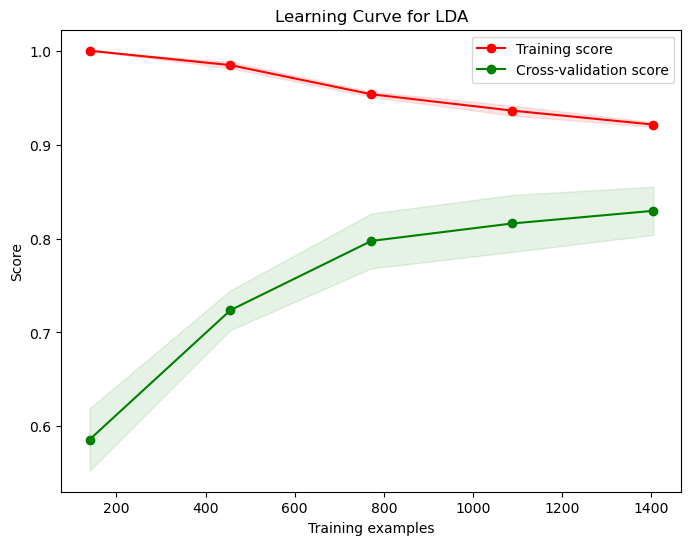

In [60]:
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    lda.best_estimator_, pca_features, class_labels, cv=10, scoring='accuracy')

# Compute mean and standard deviation of training scores and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve for LDA")
plt.legend(loc="best")
plt.savefig('LC.png', dpi=400, format='png')

### Learning Curve Analysis

The learning curve analysis for the LDA model reveals insights into the classifier's performance as the training dataset size increases:

1. **Training Score**:
   - The training score starts near perfect (100%) with a small dataset, reflecting overfitting when limited data is available.
   - As more data is added, the training score decreases slightly, stabilizing around 95%.

2. **Cross-Validation Score**:
   - The cross-validation score steadily improves as more training samples are included, starting from around 60% and reaching approximately 80%.
   - The gap between the training and cross-validation scores narrows with larger datasets, indicating reduced overfitting.

3. **Implication**:
   - The model benefits significantly from additional training data, as evidenced by the improved cross-validation score.
   - The narrowing gap between the training and cross-validation scores suggests that the LDA model is well-suited for this dataset, with no major signs of underfitting or overfitting once sufficient data is available.


### Validation Curve

Finally, we conduct a validation curve analysis for the LDA model to explore the impact of varying hyperparameters on model performance. The analysis focuses on two hyperparameters: tol, and shrinkage value.

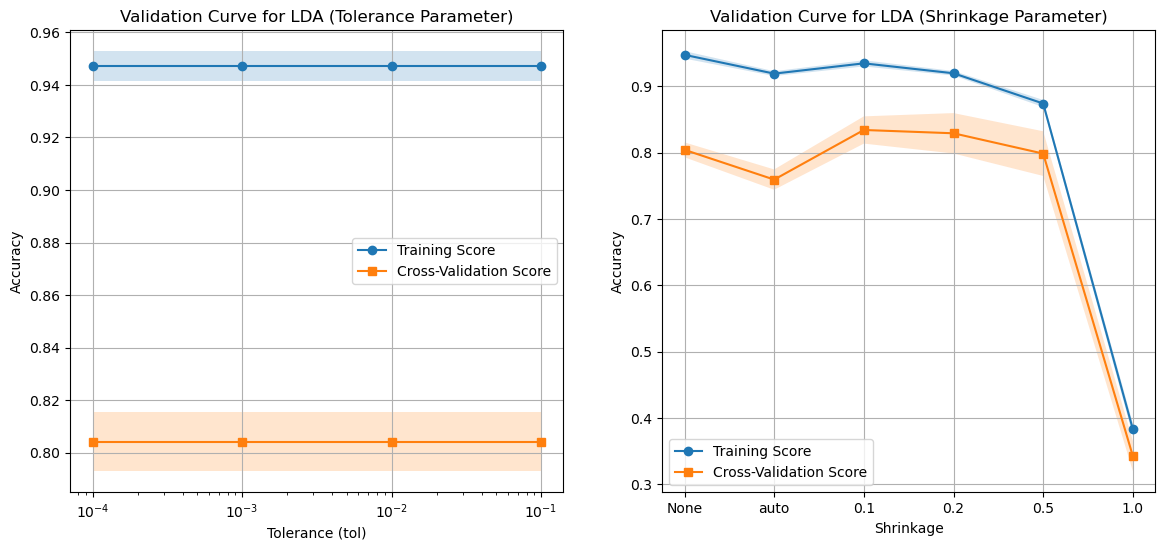

In [69]:
from sklearn.model_selection import validation_curve

# Define the range of tolerance values
tol_values = [1e-4, 1e-3, 1e-2, 1e-1]

# Create the LDA estimator with the `lsqr` solver
lda = LinearDiscriminantAnalysis(solver="lsqr")

# Compute validation curve
train_scores, val_scores = validation_curve(
    estimator=lda,
    X=X_train,
    y=y_train,
    param_name="tol",         # Only applicable for `lsqr`
    param_range=tol_values,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(tol_values, train_mean, label="Training Score", marker="o")
plt.plot(tol_values, val_mean, label="Cross-Validation Score", marker="s")
plt.fill_between(tol_values, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(tol_values, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xscale("log")
plt.title("Validation Curve for LDA (Tolerance Parameter)")
plt.xlabel("Tolerance (tol)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()

# Define the range of shrinkage values to test
shrinkage_values = [None, 'auto', 0.1, 0.2, 0.5, 1.0]

# Initialize the LDA classifier with the 'lsqr' solver
lda = LinearDiscriminantAnalysis(solver='lsqr')

# Compute validation curve
train_scores, val_scores = validation_curve(
    estimator=lda,
    X=X_train,
    y=y_train,
    param_name="shrinkage",
    param_range=shrinkage_values,
    scoring="accuracy",  # Use accuracy as the evaluation metric
    cv=5,                # 5-fold cross-validation
    n_jobs=-1            # Use all available CPU cores
)

# Compute mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

shrinkage_values = [str(val) for val in shrinkage_values]
# Plot validation curve
plt.subplot(1, 2, 2)
plt.plot(shrinkage_values, train_mean, label="Training Score", marker='o')
plt.plot(shrinkage_values, val_mean, label="Cross-Validation Score", marker='s')
plt.fill_between(shrinkage_values, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(shrinkage_values, val_mean - val_std, val_mean + val_std, alpha=0.2)

# Add labels, title, and legend
plt.title("Validation Curve for LDA (Shrinkage Parameter)")
plt.xlabel("Shrinkage")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

### Validation Curve Analysis

The validation curve analysis for the LDA model explores the impact of the **tolerance parameter (`tol`)** and **shrinkage parameter (`shrinkage`)** on the model's performance:

1. **Tolerance (`tol`)**:
   - The training score remains consistently high, around 94-96%, across all `tol` values.
   - The cross-validation score stays relatively stable, around 80%, regardless of the `tol` value.
   - **Implication**: The tolerance parameter does not significantly impact the model's performance, suggesting that the solver converges reliably across all tested tolerances.

2. **Shrinkage**:
   - Training scores decrease as the shrinkage parameter increases, especially for values beyond `0.2`.
   - Cross-validation scores peak around a shrinkage value of `0.1` and start declining for larger values.
   - **Implication**: A small amount of shrinkage (`0.1` to `0.2`) improves generalization, likely by regularizing the covariance matrix. Larger shrinkage values lead to underfitting, as indicated by the drop in both training and validation scores.

- **Validation Curves**: The `tol` parameter has minimal impact on performance, while a small amount of shrinkage improves generalization. However, excessive regularization leads to underfitting.
- **Learning Curve**: The LDA model performs better with larger datasets, demonstrating its ability to generalize effectively given enough training data. Expanding the training set further may yield additional performance gains.

### Conclusion

In this project, we explored the task of facial recognition using traditional machine learning methods on the LFW dataset. The process included the following steps:

1. **Data Preprocessing**:
   - Features were extracted from the dataset and dimensionality reduction was performed using PCA to address high dimensionality and computational complexity.
   - We also employed strategies to address class imbalance, such as weighted classifiers and data augmentation.

2. **Model Exploration**:
   - Four traditional machine learning classifiers were trained and tuned: Support Vector Machines (SVM), Logistic Regression (LR), K-Nearest Neighbors (KNN), and Linear Discriminant Analysis (LDA).
   - Hyperparameters for each model were optimized using grid search and validation curves were plotted to analyze their sensitivity to different parameters.

3. **Performance Comparison**:
   - The models were evaluated on two key metrics: accuracy (best cross-validation score) and training time.
   - The comparison revealed that:
     - KNN performed the worst in terms of accuracy, likely due to its high sensitivity to irrelevant features and class imbalance.
     - SVM, LR, and LDA showed very similar accuracy, with LDA slightly outperforming the other two.
     - LDA significantly outperformed the other models in terms of training time, making it the most efficient choice.

4. **Model Selection**:
   - Based on the analysis, LDA was chosen as the final model for this project. Its combination of strong performance and minimal training time makes it ideal for this application, especially when scalability and efficiency are key considerations.

### Final Thoughts
This project highlights the utility of traditional machine learning methods for facial recognition tasks, particularly in settings where computational efficiency is important. LDA's strong performance in both accuracy and training time demonstrates its suitability for this problem. Additionally, the detailed analysis of hyperparameters and model comparison serves as a roadmap for selecting the optimal algorithm based on both performance and practicality.